In [1]:
from Bio import SeqIO
import os
import pylcs
import numpy as np
from scipy.signal import correlate
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt

np.random.seed(23)

### Human Chr 7 and Chimp Chr 7

In this notebook, we will attempt to find regions of alignment in the first 6M base pairs of the Human chr 7 and Chimp chr 7.  We first using a custom implementation of BLAST (basic local alignment search tool) to find regions of local alignment.  Then, using another custom implementation of a local alignment algorithm using convolution to save time, we confirm alignment from the previous step.  Finally, we show that a naive implementation of LCS would be intractable with strings as long as chromosomes (1e8) or even the region we discovered (2e5).

In [2]:
file_folder = r"E:\Users\Rich\Documents\Datasets\genomes\human"
filename = r"Homo_sapiens.GRCh38.dna_rm.chromosome.7.fa"
filepath = os.path.join(file_folder, filename)

for record in SeqIO.parse(filepath, 'fasta'):
  print(record.description)
  hum = str(record.seq)
  #hum_chr15 = hum_chr15.replace('N', '')
print(len(hum))

7 dna_rm:chromosome chromosome:GRCh38:7:1:159345973:1 REF
159345973


In [3]:
file_folder = r"E:\Users\Rich\Documents\Datasets\genomes\chimp"
filename = r"Pan_troglodytes.Pan_tro_3.0.dna_rm.chromosome.7.fa"
filepath = os.path.join(file_folder, filename)

for record in SeqIO.parse(filepath, 'fasta'):
  print(record.description)
  chimp = str(record.seq)
  #hum_chr15 = hum_chr15.replace('N', '')
print(len(chimp))

7 dna_rm:chromosome chromosome:Pan_tro_3.0:7:1:166211670:1 REF
166211670


In [4]:
hum_slice = hum[800_000:6_000_000]
chimp_slice = chimp[:5_100_000]

del hum
del chimp

### 1) BLAST

In [5]:
def blast(seq1, seq2, kmers=10, kmer_length=10, max_match_len=10_000, threshold=5):
    seq1_len = len(seq1)
    seq2_len = len(seq2)
    possible_kmers = []
    seq1_index = {}
    seq2_index = {}
    
    # Produce kmers
    while len(possible_kmers) < kmers:
        start = np.random.randint(seq1_len - kmer_length)
        kmer = seq1[start:start+kmer_length]
        
        if "N" not in kmer:
            match_idx = []
            for i in range(seq2_len-kmer_length):
                if kmer == seq2[i:i+kmer_length]:
                    match_idx.append(i)
            
            if 0 < len(match_idx) < 1000:
                possible_kmers.append(kmer)
                seq2_index[kmer] = match_idx
                print(f"{kmer} ---- {len(match_idx)} ---- ", end='')
                
                match_idx = []
                for i in range(seq1_len-kmer_length):
                    if kmer == seq1[i:i+kmer_length]:
                        match_idx.append(i)
                seq1_index[kmer] = match_idx
                print(len(match_idx))
    
    
    # Calculate Local Alignment    
    for kmer in possible_kmers:
        for kmer_position_seq1 in seq1_index[kmer]:
            for kmer_position_seq2 in seq2_index[kmer]:
                alignment_info = {}
                alignment_info["kmer"] = kmer
                match_len = len(kmer)
                
                # Extend right
                right_score = len(kmer)
                right_threshold = threshold
                i = kmer_position_seq1 + kmer_length
                j = kmer_position_seq2 + kmer_length
                while i < len(seq1) and j < len(seq2):
                    if seq1[i] == seq2[j]:
                        right_score += 1
                    else:
                        right_score -= 1
                    if right_score < right_threshold:
                        break
                    i += 1
                    j += 1
                    match_len += 1
                alignment_info['seq1_end'] = i
                alignment_info['seq2_end'] = j
                
                # Extend left
                left_score = len(kmer)
                left_threshold = threshold
                i = kmer_position_seq1 - 1
                j = kmer_position_seq2 - 1
                while i > 0 and j > 0:
                    if seq1[i] == seq2[j]:
                        left_score += 1
                    else:
                        left_score -= 1
                    if left_score < left_threshold:
                        break
                    i -= 1
                    j -= 1
                    match_len += 1
                alignment_info['seq1_start'] = i
                alignment_info['seq2_start'] = j
                
                alignment_info['match_len'] = match_len
                alignment_info['score'] = right_score + left_score

                if alignment_info['match_len'] > max_match_len:
                    print(f"kmer: {alignment_info['kmer']}  match length: {alignment_info['match_len']}")
                    print(f"seq1[{alignment_info['seq1_start']}:{alignment_info['seq1_end']}]  seq2[{alignment_info['seq2_start']}:{alignment_info['seq2_end']}]")
    
    
    

In [6]:
blast(hum_slice, chimp_slice, kmers=10, kmer_length=20, max_match_len=50_000)

CCGTGGACACACCGGTGTGG ---- 1 ---- 1
CTTTCCCTCTGTTTATGCTC ---- 1 ---- 1
TTTAAGGTGACAGGAGCATA ---- 1 ---- 1
TGAGTAAGTAATTAGATAAC ---- 1 ---- 1
ACGGAAAAAGTGCACAAAGG ---- 1 ---- 1
GATCTCATTTTGGACTTTGA ---- 1 ---- 1
TCAGGAGTGGAACGTCACTC ---- 1 ---- 1
TTTTAGGTCTGGCTTACAGT ---- 1 ---- 1
CCCTTCGCCACCCTCTGCTG ---- 1 ---- 1
CAGCAGTACGTGTGTACCCA ---- 1 ---- 1
kmer: CTTTCCCTCTGTTTATGCTC  match length: 223351
seq1[4920983:5144335]  seq2[4876648:5100000]
kmer: TTTAAGGTGACAGGAGCATA  match length: 192396
seq1[2121781:2314178]  seq2[2049971:2242368]
kmer: TGAGTAAGTAATTAGATAAC  match length: 65958
seq1[4823891:4889850]  seq2[4780522:4846481]
kmer: ACGGAAAAAGTGCACAAAGG  match length: 227020
seq1[3713371:3940392]  seq2[3679569:3906590]
kmer: GATCTCATTTTGGACTTTGA  match length: 138606
seq1[2861965:3000572]  seq2[2823741:2962348]


##### Possible 10-mers after running BLAST a number of times

kmer: GATCTCATTTTGGACTTTGA

match length: 138606

seq1[2861965:3000572]  seq2[2823741:2962348]

--------------------------

kmer: GTCATTTAAAATAGGTTTAA

match length: 443282

seq1[4788084:5231367]  seq2[3931199:4374482]

--------------------------

kmer: GTAGCGTGAACAGGCTAAGA

match length: 427834

seq1[4816664:5244499]
seq2[3961348:4389183]

--------------------------

kmer: TCCTTGATTGTCTTTTCACT

match length: 233566

seq1[3962895:4196462]
seq2[3906822:4140389]

In [72]:
# Moving forward, let us use kmer: TCCTTGATTGTCTTTTCACT  match length: 233566
# hum_slice[3962895:4196462] chimp_slice[3906822:4140389]

splice1 = hum_slice[3962895:4196462]
splice2 = chimp_slice[3906822:4140389]

print(len(splice1))
print(len(splice2))

233567
233567


##### Checks

In [73]:
# Number of Aligned Matches
matches = 0
for i in range(len(splice1)):
    if splice1[i] == splice2[i]:
        matches += 1
matches

116778

In [74]:
# Longest Aligned Substring
las, x = 0, 0

for i in range(len(splice1)):
    if splice1[i] == splice2[i]:
        x += 1
    else:
        if x > las:
            las = x
            start_idx = (i, i - x)
        x = 0
print(las)
print(start_idx)

start, end = start_idx
splice1[start:end] == splice2[start:end]

1874
(101204, 99330)


True

### 2) Aligning Slices

In [75]:
def align_strands(seq1_arr, seq2_arr):

    seq1_arr = np.array(list(seq1_arr))
    seq2_arr = np.array(list(seq2_arr))

    len0 = len(seq1_arr)
    len1 = len(seq2_arr)
    total_shifts = len0 + len1 - 1

    matches = np.zeros(total_shifts, dtype=int)

    nucleotides = ['A', 'C', 'G', 'T', 'N']

    # Compute cross-correlations for each nucleotide using fftconvolve
    for nucleotide in nucleotides:
        seq0_binary = (seq1_arr == nucleotide).astype(int)
        seq1_binary = (seq2_arr == nucleotide).astype(int)
        
        # Reverse seq1_binary because fftconvolve performs convolution, not correlation
        seq1_binary_reversed = seq1_binary[::-1]
        
        # Compute convolution using FFT
        conv_result = fftconvolve(seq0_binary, seq1_binary_reversed, mode='full')
        
        # Since the result may have small imaginary parts due to numerical errors, take the real part
        conv_result = np.round(np.real(conv_result)).astype(int)
        
        matches += conv_result
    
    return matches

In [76]:
def matches_to_freq(seq1, seq2, matches):
    seq1_len = len(seq1)
    seq2_len = len(seq2)
    overlap = min(seq1_len, seq2_len)
    misc = abs(seq1_len - seq2_len)
    
    front = np.arange(1, overlap)
    middle = np.full(misc + 1, overlap)
    back = front[::-1]
    overlaps = np.concatenate([front, middle, back])
    
    freq = matches / overlaps
    return freq

In [90]:
matches = align_strands(splice1, splice2)
max_alignment = np.argmax(matches)
print("Most bases alignment:", matches[max_alignment])
print("Index to align:", max_alignment)


Most bases alignment: 118446
Index to align: 233542


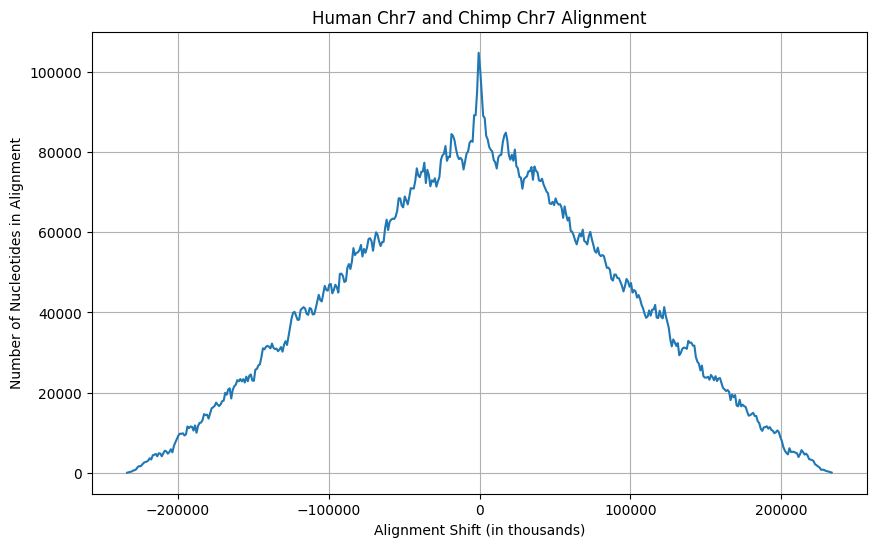

In [91]:
plt.figure(figsize=(10, 6))
step = 1_000
alignment_shift = [i - len(splice1) for i in range(len(matches))]
plt.plot(alignment_shift[::step], matches[::step])
plt.title('Human Chr7 and Chimp Chr7 Alignment')
plt.xlabel('Alignment Shift (in thousands)')
plt.ylabel('Number of Nucleotides in Alignment')
plt.grid(True)
plt.show()

In [92]:
freq = matches_to_freq(splice1, splice2, matches)

#max_alignment = np.argmax(freq[10_000:-10_000])
print("Highest base alignment freq:", freq[max_alignment])
print("Index to align:", max_alignment)

Highest base alignment freq: 0.5071699858270211
Index to align: 233542


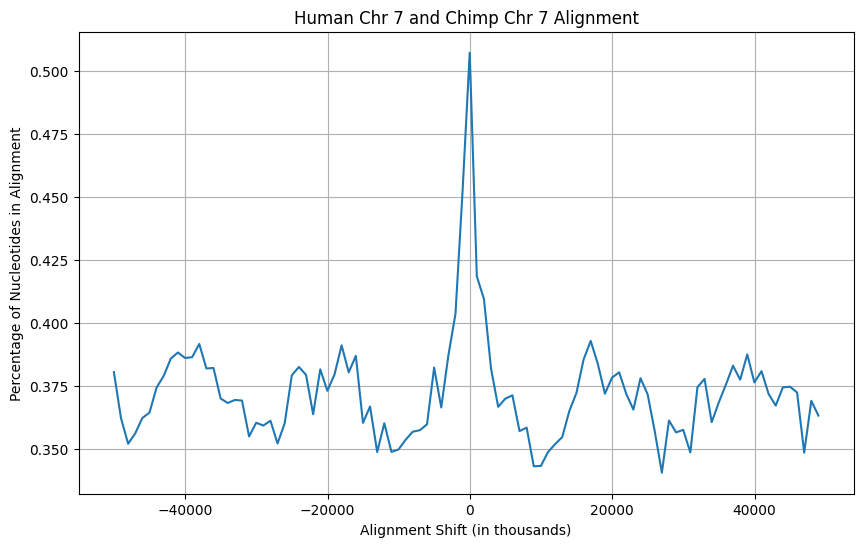

In [100]:
start = max_alignment - 50_000
end = max_alignment + 50_000
plt.figure(figsize=(10, 6))
plt.plot(alignment_shift[start:end:1000], freq[start:end:1000])
plt.title(f'Human Chr 7 and Chimp Chr 7 Alignment')
plt.xlabel('Alignment Shift (in thousands)')
plt.ylabel('Percentage of Nucleotides in Alignment')
plt.grid(True)
plt.show()

### 3) Longest Common Subsequence

Using BLAST, we found an alignment on the human chr7 and chimp chr7 of length 233567.  Calculating LCS on these regions is intractable since the dp matrix would size 233567x233567, or 5e10.  Using int32 for each element, we would need 204 GB of available RAM to run LCS.

In [82]:
length = 233567
bytes_per_element = 32 / 8
GB = 1024**3

length**2 * bytes_per_element / GB

203.22778630629182

In [83]:
# pylcs.lcs_string_length(splice1, splice2)